# **Initialization**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

!pip install optuna
import optuna

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten, Input, Layer, InputSpec
from keras.initializers import glorot_uniform, ones, zeros
import keras.backend as K

!git clone https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-.git
import os
os.chdir('/content/Survival-Analysis-Deep-Learning-AML-/Data')

# **Data**

In [86]:
patient_data = pd.read_excel("Table 10.xlsx").sort_index()
gene_expression = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
models = []
ind_shuffle = 0 

# **Auxiliary functions**

In [87]:
def plot(history,size):

    fig = plt.figure(figsize=(size*2,size))

    plt.subplot(1,2,1)
    x_axis = np.arange(1, len(history.history['loss'])+1)
    plt.plot(x_axis, history.history['loss'], label='training')
    plt.plot(x_axis, history.history['val_loss'], label='validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # plt.subplot(1,2,2)
    # x_axis = np.arange(1, len(history.history['accuracy'])+1)
    # plt.plot(x_axis, history.history['accuracy'], label='training')
    # plt.plot(x_axis, history.history['val_accuracy'], label='validation')
    # plt.title('Training and validation accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend(loc='lower right')

    return fig

In [88]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        print(" This is the best trial so far")
        # study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
        # study.set_user_attr(key="training_loss", value=trial.user_attrs["training_loss"])
        # study.set_user_attr(key="validation_loss", value=trial.user_attrs["validation_loss"])

# **Auto-encoding**

In [89]:
def Auto_encoder(input_size, structure):
    
    hidden_layers   = structure['hidden layers']
    embedding_size  = structure['embedding layer']
    activation      = structure['activation']
    drop            = structure["dropout rate"]

    structure       = hidden_layers + [embedding_size] + hidden_layers[::-1]
    
    coder_length    = len(hidden_layers)

    model           = Sequential(name = "Auto-encoder")

    model.add(Input(shape   = (input_size,), 
                    name    = "Input"))
    
    names           = ["Encoding_layer-"]*coder_length + ["Embedding_layer"] + ["Decoding_layer-"]*coder_length
    numbers         = np.concatenate((np.array(range(coder_length)) + 1, np.array(range(coder_length))+1)).tolist()

    numbers.insert(coder_length, "")

    for i,j in enumerate(structure):
        model.add(Dense(j,
                        kernel_initializer  = glorot_uniform(),
                        activation          = activation,
                        name                = "{}{}".format(names[i],numbers[i]))
        )
        model.add(Dropout(drop,
                          name = "Dropout-{}".format(i+1)))
    
    model.add(Dense(input_size,
                    kernel_initializer  = glorot_uniform(),
                    activation          = activation,
                    name                = "Output")
    )

    return model


In [90]:
def par_tuner(trial):

    global gene_expression, models, ind_shuffle

    #gene_expression = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
    gene_expression = gene_expression.astype("float32")
    input_dim       = gene_expression.shape[1]

    scaler = MinMaxScaler()
    gene_expression = pd.DataFrame(scaler.fit_transform(gene_expression))

    num_patients    = gene_expression.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = gene_expression.iloc[ind_shuffle][:train_size]
    x_test      = gene_expression.iloc[ind_shuffle][train_size:]

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    embedding_layer = 2 #trial.suggest_int("embedding layer size", 10, 50)
    activation      = trial.suggest_categorical("activation", ["relu", "selu"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-4, 1)
    momentum        = trial.suggest_float("momentum", 0, 0.999)

    tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)
    tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum)

    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 2000)
        hidden_layers.append(hlayer)

    structure = {"hidden layers"    :   hidden_layers,
                 "embedding layer"  :   embedding_layer,
                 "activation"       :   activation,
                 "dropout rate"     :   dropout_rate}

    model = Auto_encoder(input_dim, structure)

    model.compile(loss      = "mse", 
                  optimizer = optimizer,
                  metrics   = ["accuracy"])

    history = model.fit(x_train, 
                        x_train,
                        epochs          = 100,
                        validation_data = (x_test,x_test),
                        verbose = False)
    
    global models
    models.append(model)
    
    accuracy    = model.evaluate(x_test,x_test, verbose = False)
    plot(history,10)
    return accuracy[0]

In [91]:
def find_parameters(n):

    global models 
    models = []
    study = optuna.create_study(direction = "minimize", study_name = "Tuning auto-encoder")
    study.optimize(par_tuner, n_trials=n, callbacks= [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    n_encoding_layers   = trial.params["N_layers"] 
    encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    encoder             = Sequential(encoding_layers) 

    encoder.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return trial, autoencoder, encoder

# **Clustering**

In [92]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [101]:
def kl_loss():
    def loss(y_true, y_pred):
        q = y_pred
        p = K.square(q) / K.sum(q, axis=0)
        p = K.transpose( K.transpose(p) / K.sum(q, axis=1))
        return K.sum(p*K.log(p/q))
    return loss

[I 2021-10-18 17:38:34,227] A new study created in memory with name: Tuning auto-encoder
[I 2021-10-18 17:40:21,394] Trial 0 finished with value: 0.057770080864429474 and parameters: {'N_layers': 5, 'activation': 'selu', 'optimizer': 'SGD', 'dropout rate': 0.19084664818529873, 'learning rate': 0.8013359343369525, 'momentum': 0.7595442239421857, 'hlay 1': 1213, 'hlay 2': 436, 'hlay 3': 1301, 'hlay 4': 1716, 'hlay 5': 915}. Best is trial 0 with value: 0.057770080864429474.


 This is the best trial so far
Number of finished trials: 1
Best trial:
  Value: 0.057770080864429474
  Params: 
    N_layers: 5
    activation: selu
    optimizer: SGD
    dropout rate: 0.19084664818529873
    learning rate: 0.8013359343369525
    momentum: 0.7595442239421857
    hlay 1: 1213
    hlay 2: 436
    hlay 3: 1301
    hlay 4: 1716
    hlay 5: 915


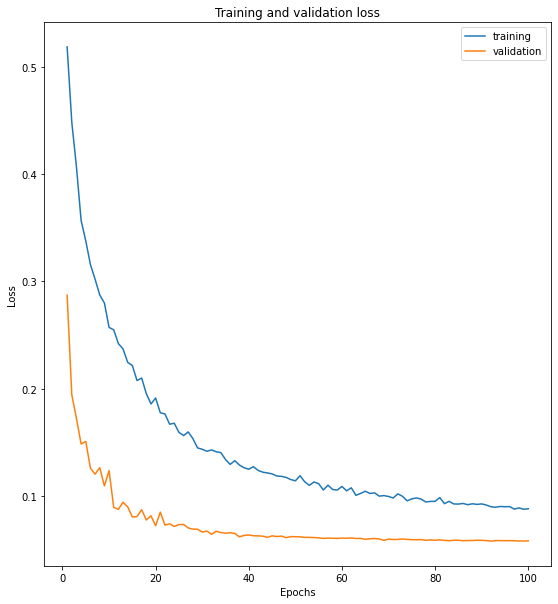

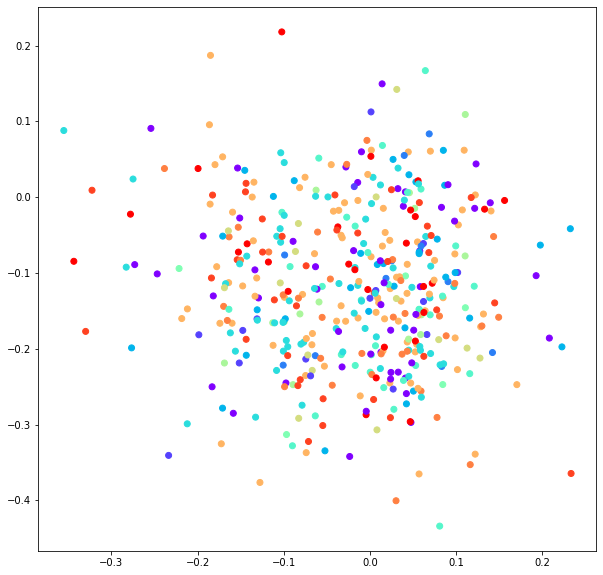

In [98]:
trial, autoencoder, encoder = find_parameters(1) #performs hyperparameter tuning on the autoencoding network and returns the hyperparameters, as well as the autoencoder end-to-end and the encoding part of the network
x = encoder.predict(gene_expression.astype("float32"))

num_colors = len(np.unique(labels))
colors = plt.get_cmap('rainbow', num_colors)
fig2 = plt.figure(figsize=(10,10))
plt.scatter(x[:,0], x[:,1], c= colors(labels))

In [99]:
encoder.add(ClusteringLayer(10)) # add the clustering layer that outputs the soft labeling q

In [107]:
y = None
# y = np.zeros((435,10))

encoder.compile(optimizer="adam", loss= kl_loss())
encoder.fit(x = gene_expression.astype('float32'), y = y, epochs = 100, verbose = False)

ValueError: ignored